# MNIST-Vanilla GAN tutorial

This is a tutorial for Vanilla GAN over MNIST dataset.
Vanilla GAN is a Adversarial Nets model, proposed by [Ian Goodfellow et al (2014)](https://arxiv.org/abs/1406.2661).
This tutorial references model architecture of Vanilla GAN described [here](https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/)

## Setting

   * Pytorch
   * Torchvision (+ cudatoolkit)
   * GPU environment (if possible)
   * Anaconda for version management

## Dataset

  * [MNIST dataset](http://yann.lecun.com/exdb/mnist/): Here train and test images are merged into one csv file of 70k images: [mnist-all-70k.csv](https://github.com/phucdoitoan/GAN/tree/master/runGAN/input_pytorch)

## Model architecture: 

### Vanilla GAN


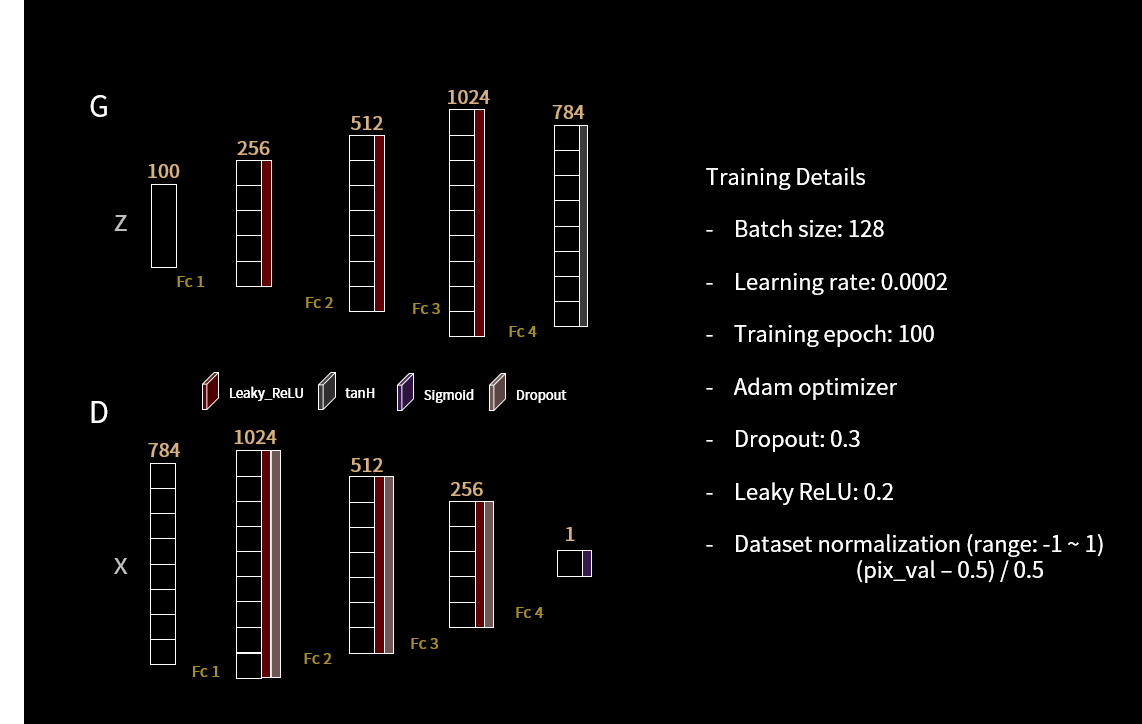

# Implementation

The following is an implementation of Vanilla GAN using PyTorch in Jupyter Notebook.
> Complete, ready-to-run verison of the code can be found in [mnist-GAN.py](https://github.com/phucdoitoan/GAN/tree/master/runGAN)

**The procedure is divided into 7 steps, the last two are just for saving loss, parameters data into csv files:**

  1. libraries loading
  2. data prepare + batch_size + num of iteration + epochs
  3. defining Generator and Discriminator models 
  4. instantiate Generator and Discriminator + loss function + learning_rate + optimizers
  5. training D and G
  6. save loss, D G parameters to csv files
  7. visualize samples generated by G


### Notes: 
**Besides Algorithm 1 described in the original paper, some tricks for better training GAN model are employed. More details [here](https://github.com/soumith/ganhacks)**
  * normalize the inputs: between -1 and 1
  * use a sperical z: sample noise from a Gaussian distribution
  * batch norm: different mini-batch for real and fake images
  * avoid sparse gradients: ReLU => use LeakyReLU instead
  * use the Adam optimizer
  * use labels if available: train D to also clssify the samples (planned to applied but haven't)

## Step 1: Libraries loading

In [8]:
# 1. libraries loading

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
from torchvision.utils import save_image

from torch.autograd import Variable
from sklearn.model_selection import train_test_split

from timeit import default_timer as timer

## Step 2: Loading data

### Loading data from csv file, define detail information:
  * define dtype to use CPU or GPU if available
  * loading and normalizing pixel value between -1 and 1:
    $$(\frac{pix\_val}{255} - 0.5)*2$$
  * the model will be trained with mini batch size of 128 over 200 epoches
  * define DataSet and DataLoader
  * define sample_noise for randomly returning a mini batch of noise sampled from normal distribution N(1,0)
  * finally, visualize first four digits in the data set
    

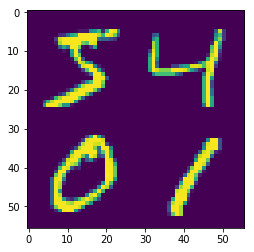

In [9]:
# 2. data loading + batch_size + epochs + batch_num

# gpu or cpu
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# loading data + normalize pixels' values between -1 and +1
data = pd.read_csv('input_pytorch/mnist-all-70k.csv')
#labels = data.label.to_numpy()
img_digits = (data.loc[:, data.columns != 'label'].values/255 - 0.5)*2

# batch_size + iteration num
batch_size = 128
epochs_num = 200

# change DataFrame to numpy
digits_Tensor = torch.Tensor(img_digits).type(dtype)

# build Dataset
digits_DataSet = torch.utils.data.TensorDataset(digits_Tensor)

# build DataLoader
digits_DataLoader = torch.utils.data.DataLoader(digits_DataSet, batch_size = batch_size)

# define function to randomly return a batch of noise
def sample_noise(size=batch_size):
    batch = torch.from_numpy(np.random.randn(size,100)).type(dtype)
    return batch

# visualize data
first_four = np.append(np.append(img_digits[0].reshape(28,28), img_digits[1].reshape(28,28), axis=0), np.append(img_digits[2].reshape(28,28), img_digits[3].reshape(28,28), axis = 0), axis=1)
plt.imshow(first_four)

## Step 3: Define G and D model

**Both Generator and Discriminator are neural network**
  * Generator takes 100-dimension noise vector sampled from Gaussian Distribution as input. It has three fully connected hidden layers of 256, 512, 1024 nodes and an output layer of  28*28 = 784 nodes. Each hidden layer is activated by LeakyReLU activation function. The activation function for output layer is Tanh.
  * Discriminator takes 784-dimension vector as input. It also has three hidden layer of 1024, 512, 256 nodes, in opposite to Generator. Discriminator outputs one scalar to detect whether the input comes from real data set or not. Hidden layers are equipped with LeakyReLU activation function and an Dropout layer. Output scalar is activated with Sigmoid.
  * LeakyReLU's negative slope = 0.2 and Dropout probability p = 0.2 

In [11]:
# 3. defining Generator and Discriminator

# generator: 100 -> 256 -> 512 -> 1024 -> 784
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Generator, self).__init__()
        
        # 1st layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.ac1 = nn.LeakyReLU(negative_slope=0.2)
        # 2nd layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.ac2 = nn.LeakyReLU(negative_slope=0.2)
        # 3rd layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.ac3 = nn.LeakyReLU(negative_slope=0.2)
        # 4th layer (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.ac4 = nn.Tanh()
        
    def forward(self, x):
        out1 = self.ac1(self.fc1(x))
        out2 = self.ac2(self.fc2(out1))
        out3 = self.ac3(self.fc3(out2))
        out = self.ac4(self.fc4(out3))
        
        return out
    
# discriminator: 784 -> 1024 -> 512 -> 256 -> 1
class Discriminator(nn.Module):
    def __init__(self,input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Discriminator, self).__init__()
        
        # 1st layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.ac1 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout1 = nn.Dropout(p=0.3)
        # 2nd layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.ac2 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        # 3rd layer
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.ac3 = nn.LeakyReLU(negative_slope=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
        # 4th layer (readout)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.ac4 = nn.Sigmoid()
        
    def forward(self, x):
        out1 = self.dropout1(self.ac1(self.fc1(x)))
        out2 = self.dropout2(self.ac2(self.fc2(out1)))
        out3 = self.dropout3(self.ac3(self.fc3(out2)))
        out = self.ac4(self.fc4(out3))
        
        return out
        

## Step 4: Instantiate G and D

  * instantiate Generator and Discriminator and change parameter tensors' type to dtype (defined above, determined using CPU or GPU)
  * follow original paper, binary cross entropy loss function is used
  * learning rate is 0.0002
  * both optimizers for G and D are Adam

In [12]:
# 4. instantiate G and D; loss function; learning_rate; optimizers

# generator + discriminator
G = Generator(100, 256, 512, 1024, 784).type(dtype)
D = Discriminator(784, 1024, 512, 256, 1).type(dtype)

# loss function: Binary Cross Entropy Loss
error = nn.BCELoss()

# learning rate
learning_rate = 0.0002

# optimizers: 
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate)


**Visualize a sample generated by G before training: The image shows random pattern of pixel's value**

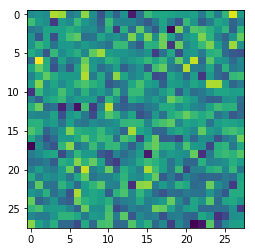

In [13]:
# visualize image generated by generator before training
before_noise = sample_noise(1)
before_result = G(before_noise)

before_img = before_result.detach().cpu().numpy().reshape(28,28)
plt.imshow(before_img)

## Step 5: Training D and G

### Train D one times
**Train D to dicriminate real data from samples generated from noise**
  1. Two mini batches are drawn to train D: one real mini batch of only real data and one fake mini batch of only samples generated from noise
  2. D is updated seperatedly after being trained with real mini batch and after being trained with fake mini batch
  
### Train G one times
**Train G so that D makes mistake and classify samples generated from G as real data**
  1. Feed D a mini batch of fake samples generated by G; however, this time, the fake samples are labeled with 1 (which means D mis-classifies them)
  
**Notes: some tensors' type needs to be changed to dtype to be compatible with GPU (if available)**

G_generate is used to save samples generated by G after each epoch of training

```
```

> **Training a neural network can be done as:**
  * clear gradient: in pytorch, gradients are accumulated, hence they need to be reset after each parameter updating 
  * forward propagation: calculate output
  * define corresponding labels (if needed) and compute loss
  * back propagation: compute gradients
  * update parameters according to gradients

In [42]:
# 5. training D and G

# list to store loss, iter
G_loss_list = []
D_real_loss_list = []
D_fake_loss_list = []
iter_list = []

# function to save digit images generated by G after each epoch
def G_generate(epoch, size=batch_size):
    generated = G(sample_noise(size)).cpu() #copy tensor to host
    save_image(generated.view(generated.size(0), 1, 28, 28), 'results/digits_in_epochs/epoch' + str(epoch) + '.png')

all_start = timer()
for epoch in range(epochs_num): #epochs_num
    epoch_start = timer()
    for it, [real_batch] in enumerate(digits_DataLoader):
        
        ##### TRAIN D  #####
        # on real batch
        # clear gradients
        D_optimizer.zero_grad()
        # forward propagation
        real_out = D(real_batch)
        # soft label for real batch: 1
        real_label = torch.ones(real_out.shape[0], 1).type(dtype)
        # loss
        D_real_loss = error(real_out, real_label)
        # back propagation
        D_real_loss.backward()
        # update parameters
        D_optimizer.step()
    
        # on fake batch
        # sample noise + generate fake batch
        noise_batch = sample_noise()
        fake_batch = G(noise_batch)
        # clear gradients
        D_optimizer.zero_grad()
        # forward propagation
        fake_out = D(fake_batch)
        # soft label for fake batch: 0
        fake_label = torch.zeros(fake_out.shape[0], 1).type(dtype)
        # loss
        D_fake_loss = error(fake_out, fake_label)
        # back propagation
        D_fake_loss.backward()
        # update parameters
        D_optimizer.step()        
        
        ##### TRAIN G #####
        # sample noise + generate fake batch
        noise_batch = sample_noise()
        fake_batch = G(noise_batch)
        # clear gradients
        G_optimizer.zero_grad()
        # forward propagation
        fake_out = D(fake_batch)
        # soft label for fake batch: 1
        fake_label = torch.ones(fake_out.shape[0], 1).type(dtype)
        # loss 
        G_loss = error(fake_out, fake_label)
        # back propagation
        G_loss.backward()
        # update parameters
        G_optimizer.step()
        
        ##### store loss, it #####
        if it % 500 == 0:
            iter_list.append(it+batch_num*epoch)
            G_loss_list.append(G_loss.item())
            D_fake_loss_list.append(D_fake_loss.item())
            D_real_loss_list.append(D_real_loss.item())
                    
            #print('Epoch {} [{}/{}]:'.format(epoch, it, batch_num))

    print('Epoch {} :'.format(epoch))  
    print('    G_loss: {}'.format(G_loss.item()))
    print('    D_fake_loss: {}'.format(D_fake_loss.item()))
    print('    D_real_loss: {}'.format(D_real_loss.item()))
            
    epoch_duration = timer() - epoch_start
    G_generate(epoch)
    print('##### TRAIN EPOCH {} IN {} s #####'.format(epoch, epoch_duration))
    
all_duration = timer() - all_start
print('ALL TRAINING TIME: {}'.format(all_duration))

Epoch 0 :
    G_loss: 2.2869467735290527
    D_fake_loss: 0.26757678389549255
    D_real_loss: 0.19511725008487701
##### FINISH EPOCH 0 IN 71.31330977399921 s #####
Epoch 1 :
    G_loss: 7.8009867668151855
    D_fake_loss: 0.002192980609834194
    D_real_loss: 0.07122142612934113
##### FINISH EPOCH 1 IN 65.30272251800488 s #####
Epoch 2 :
    G_loss: 4.42112922668457
    D_fake_loss: 0.10590638220310211
    D_real_loss: 0.005309301428496838
##### FINISH EPOCH 2 IN 69.82702735100611 s #####
Epoch 3 :
    G_loss: 5.201483726501465
    D_fake_loss: 0.03442748263478279
    D_real_loss: 0.04643922671675682
##### FINISH EPOCH 3 IN 66.01550307199795 s #####
Epoch 4 :
    G_loss: 2.7224769592285156
    D_fake_loss: 0.3737214505672455
    D_real_loss: 0.06419702619314194
##### FINISH EPOCH 4 IN 64.8292075759964 s #####
Epoch 5 :
    G_loss: 4.400238990783691
    D_fake_loss: 0.01566293090581894
    D_real_loss: 0.26212799549102783
##### FINISH EPOCH 5 IN 71.308047945 s #####
Epoch 6 :
    G_los

Epoch 50 :
    G_loss: 1.2762398719787598
    D_fake_loss: 0.5789357423782349
    D_real_loss: 0.3819562494754791
##### FINISH EPOCH 50 IN 70.2788940649989 s #####
Epoch 51 :
    G_loss: 1.0562822818756104
    D_fake_loss: 0.5770220756530762
    D_real_loss: 0.4353843331336975
##### FINISH EPOCH 51 IN 69.37782579899795 s #####
Epoch 52 :
    G_loss: 1.0938270092010498
    D_fake_loss: 0.7285094261169434
    D_real_loss: 0.43764954805374146
##### FINISH EPOCH 52 IN 68.5601895830041 s #####
Epoch 53 :
    G_loss: 1.1660124063491821
    D_fake_loss: 0.5502867698669434
    D_real_loss: 0.4353358745574951
##### FINISH EPOCH 53 IN 67.39454293499875 s #####
Epoch 54 :
    G_loss: 1.4934754371643066
    D_fake_loss: 0.5194198489189148
    D_real_loss: 0.4147755801677704
##### FINISH EPOCH 54 IN 68.75672062800004 s #####
Epoch 55 :
    G_loss: 1.2853078842163086
    D_fake_loss: 0.6078550815582275
    D_real_loss: 0.4528520405292511
##### FINISH EPOCH 55 IN 66.88588567099941 s #####
Epoch 56 :


Epoch 100 :
    G_loss: 0.9520758390426636
    D_fake_loss: 0.6522501707077026
    D_real_loss: 0.4476749002933502
##### FINISH EPOCH 100 IN 72.3064014929987 s #####
Epoch 101 :
    G_loss: 1.009444236755371
    D_fake_loss: 0.6452954411506653
    D_real_loss: 0.44913190603256226
##### FINISH EPOCH 101 IN 72.05163074900338 s #####
Epoch 102 :
    G_loss: 0.9065823554992676
    D_fake_loss: 0.6792272329330444
    D_real_loss: 0.48988714814186096
##### FINISH EPOCH 102 IN 69.22217531700153 s #####
Epoch 103 :
    G_loss: 0.8924546837806702
    D_fake_loss: 0.8086893558502197
    D_real_loss: 0.5062676072120667
##### FINISH EPOCH 103 IN 63.777114957003505 s #####
Epoch 104 :
    G_loss: 0.8798165917396545
    D_fake_loss: 0.7422948479652405
    D_real_loss: 0.4272737205028534
##### FINISH EPOCH 104 IN 63.34476159299811 s #####
Epoch 105 :
    G_loss: 0.8982536792755127
    D_fake_loss: 0.6327285170555115
    D_real_loss: 0.4893508851528168
##### FINISH EPOCH 105 IN 62.900140124002064 s ##

Epoch 150 :
    G_loss: 0.8623337149620056
    D_fake_loss: 0.6429218053817749
    D_real_loss: 0.5014259815216064
##### FINISH EPOCH 150 IN 64.84823774699908 s #####
Epoch 151 :
    G_loss: 1.058093786239624
    D_fake_loss: 0.5879355669021606
    D_real_loss: 0.5363866090774536
##### FINISH EPOCH 151 IN 62.61183131100552 s #####
Epoch 152 :
    G_loss: 0.9487388134002686
    D_fake_loss: 0.5640302300453186
    D_real_loss: 0.5515490174293518
##### FINISH EPOCH 152 IN 68.7678596850019 s #####
Epoch 153 :
    G_loss: 0.8457081913948059
    D_fake_loss: 0.6362163424491882
    D_real_loss: 0.48331549763679504
##### FINISH EPOCH 153 IN 67.63706338599877 s #####
Epoch 154 :
    G_loss: 0.9453814625740051
    D_fake_loss: 0.6892642378807068
    D_real_loss: 0.39775973558425903
##### FINISH EPOCH 154 IN 65.6596475549959 s #####
Epoch 155 :
    G_loss: 0.7982054352760315
    D_fake_loss: 0.6897302865982056
    D_real_loss: 0.5376530885696411
##### FINISH EPOCH 155 IN 69.83161093100352 s #####

## Step 6: Save loss and parameters


loss and parameters of trained G and D are save into csv file


In [14]:
# 6. save loss, D G parameters to csv files

# save loss
def save_loss(iter_list, G_loss_list, D_fake_loss_list, D_real_loss_list, path):
    pd.DataFrame({'iteration': iter_list, 'G_loss': G_loss_list, 'D_fake_loss': D_fake_loss_list, 'D_real_loss': D_real_loss_list}).to_csv(path, index = False)
    
save_loss(iter_list, G_loss_list, D_fake_loss_list, D_real_loss_list, 'results/loss.csv')

# save parameters
def save_parameters(paras, path):    
    for i, para in enumerate(paras):
        pd.DataFrame(para.detach().cpu().numpy()).to_csv(path + 'para_' + str(i) + '.csv', index = False)
        
# save paras of trained G
save_parameters(G.parameters(), 'results/G_para/')
# save paras of trained D
save_parameters(D.parameters(), 'results/D_para/')

print('saved loss, D G parameters')

NameError: name 'iter_list' is not defined

## Step 7: Load loss + parameters back and visualize

load loss from loss.csv file and plot the loss figure

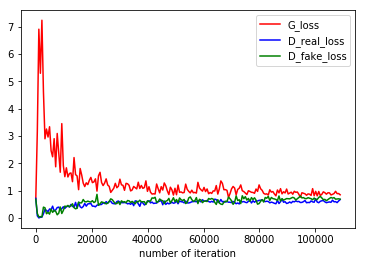

In [17]:
# 7. visualize loss and samples generated by G

# load loss
def load_loss(path):
    tmp = pd.read_csv(path)
    iter_list = tmp.loc[:, tmp.columns == 'iteration'].to_numpy().tolist()
    G_loss = tmp.loc[:, tmp.columns == 'G_loss'].to_numpy().flatten().tolist()
    D_real_loss = tmp.loc[:, tmp.columns == 'D_real_loss'].to_numpy().flatten().tolist()
    D_fake_loss = tmp.loc[:, tmp.columns == 'D_fake_loss'].to_numpy().flatten().tolist()
    
    return iter_list, G_loss, D_real_loss, D_fake_loss

iter_list, G_loss_list, D_real_loss_list, D_fake_loss_list = load_loss('results/loss.csv')

# plot D and G loss
fig = plt.figure()
plt.plot(iter_list[::2], G_loss_list[::2], color = 'r', label='G_loss')
plt.plot(iter_list[::2], D_real_loss_list[::2], color = 'b', label='D_real_loss')
plt.plot(iter_list[::2], D_fake_loss_list[::2], color = 'g', label='D_fake_loss')
plt.xlabel('number of iteration')
plt.legend()
#plt.show()
fig.savefig('results/plot/loss_plot.png')


### load parameters into a newly instantiated Generator
the parameter-loaded Generator produces MNIST-alike digit images

In [22]:
# function to load para from csv file
def load_parameters(path):
    tmp = pd.read_csv(path)
    tmp = tmp.to_numpy()
    if tmp.shape[1] == 1:
        tmp = tmp.flatten()
    return torch.from_numpy(tmp)

new_G = Generator(100, 256, 512, 1024, 784)

# load para from csv files to new_G model
for i, para in enumerate(new_G.parameters()):
    para.data = load_parameters('results/G_para/para_'+ str(i) + '.csv').type(dtype)


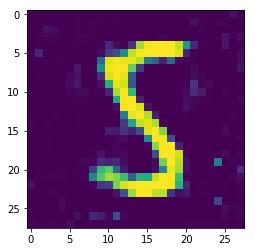

In [23]:
# visualize samples generated by new_G loaded with para
generated = new_G(sample_noise())
img_test = generated[0].detach().cpu().numpy().reshape(28,28)
plt.imshow(img_test)